# EDA of the training data

In [110]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import torch

PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
DB_PATH: str = str(DATA_DIR / "ruokasuositusdata.db")

In [111]:
with sqlite3.connect(DB_PATH) as conn:
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM dishes")
    rows = cursor.fetchall()

dishes_df = pd.DataFrame(rows, columns=["id", "Nimi", "Kuvaus", "Pääraaka-aine", "Raskas", "Hinta", "Toistuvuus"]).drop(columns=["id"]).dropna()

In [112]:
with sqlite3.connect(DB_PATH) as conn:
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM training")
    rows = cursor.fetchall()

score_data = pd.DataFrame(rows, columns=["id", "a", "b", "c", "score"]).drop(columns=["id"]).dropna()
score_data["score"] = score_data["score"].astype(int)
score_data

,a,b,c,score
0,Gnocchivuoka,Tomaattikeitto,Uuniperunat (skagen),4
1,Tonnikalapastavuoka,Kalakeitto,Uunilohi,1
2,Kanapasta,Vihreä pasta,Gyros,4
3,Kalapuikot,Gnocchivuoka,Kasvislasagne,2
4,Kalapuikot,Tonnikalapastavuoka,Savulohi,1
...,...,...,...,...
495,Vihreä pasta,Gnocchivuoka,Uuniperunat (skagen),1
496,Burrito,Halloumipasta,Paistetut nuudelit,5
497,Tonnikalapastavuoka,Kanapasta,Uuniperunat (skagen),3
498,Katkarapupasta,Tonnikalapastavuoka,Kanafileet,3


## Initial analysis

In [113]:
score_data.sort_values(by="score", ascending=False).head()

,a,b,c,score
332,Katkarapupasta,Tonnikalapastavuoka,Paistetut nuudelit,5
55,Sosekeitto,Halloumipasta,Savulohi,5
355,Kalapuikot,Burrito,Paprikapasta,5
360,Uunifetapasta,Arkipizza (kana),Uuniperunat (skagen),5
266,Katkarapuwokki,Tonnikalapastavuoka,Kanakastike ja riisi,5


<Axes: >

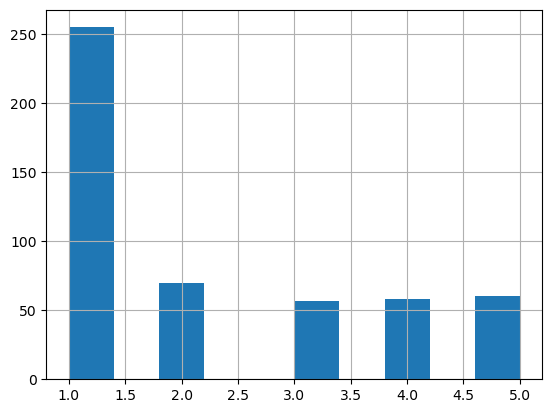

In [114]:
score_data.score.hist()

In [115]:
# Which dishes appeared most often in sets with score >= 4?
score_data[score_data["score"]>=4].iloc[:,:3].stack().reset_index(drop=True).value_counts().head()

Gnocchivuoka            23
Paistetut nuudelit      22
Kalapuikot              22
Halloumipasta           18
Uuniperunat (skagen)    17
Name: count, dtype: int64

## Feature Engineering
First, I built similar features as in `training_data.ipynb` with grouped counts of dummy variables.

In [116]:
data = score_data.copy()

name_to_id = dict(zip(dishes_df["Nimi"].to_list(), dishes_df.index))
id_to_name = dishes_df["Nimi"].to_dict()

for col in ["a", "b", "c"]:
    data[col] = data[col].map(lambda x: name_to_id[x])

dish_features = pd.get_dummies(dishes_df.drop(columns=["Nimi", "Kuvaus"]),
                   columns=["Pääraaka-aine", "Raskas", "Hinta", "Toistuvuus"])
dish_features_columns = dish_features.columns.to_list()
dish_features = dish_features.to_numpy()
indexes = data.iloc[:,:3].to_numpy()
X = np.array([dish_features[list(idx_triple)].sum(axis=0) for idx_triple in indexes])

feature_df = pd.DataFrame(X, columns=dish_features_columns)
feature_df.insert(len(feature_df.columns), "score", data["score"])
feature_df

,Pääraaka-aine_Kala,Pääraaka-aine_Kana,Pääraaka-aine_Kasvis,Pääraaka-aine_Katkarapu,Raskas_1,Raskas_2,Raskas_3,Hinta_1,Hinta_2,Hinta_3,Toistuvuus_1,Toistuvuus_2,Toistuvuus_3,Toistuvuus_4,score
0,0,0,2,1,1,1,1,1,1,1,1,1,1,0,4
1,3,0,0,0,0,2,1,0,2,1,1,1,0,1,1
2,0,2,1,0,1,2,0,0,1,2,1,1,1,0,4
3,1,0,2,0,0,2,1,1,2,0,0,2,1,0,2
4,3,0,0,0,1,1,1,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,0,2,1,1,1,1,0,1,2,1,1,1,0,1
496,0,2,1,0,2,0,1,0,3,0,0,2,1,0,5
497,1,1,0,1,0,2,1,0,2,1,0,1,1,1,3
498,1,1,0,1,1,0,2,0,1,2,1,1,0,1,3


Then, I tried more features to better capture the diversity of dishes in a set.

In [117]:
feature_df["protein_entropy"] = feature_df.apply(lambda row: -np.array([x/3 * np.log2(x/3) if x > 0 else 0 for x in row[:4]]).sum(), axis=1)
feature_df["raskas_entropy"] = feature_df.apply(lambda row: -np.array([x/3 * np.log2(x/3) if x > 0 else 0 for x in row[4:7]]).sum(), axis=1)
feature_df["hinta_entropy"] = feature_df.apply(lambda row: -np.array([x/3 * np.log2(x/3) if x > 0 else 0 for x in row[7:10]]).sum(), axis=1)

feature_df["raskas_var"] = feature_df.apply(lambda row: np.var(row[4:7]), axis=1)
feature_df["raskas_mean"] = feature_df.apply(lambda row: np.mean(row[4:7]), axis=1)

feature_df["raskas_sum"] = feature_df["Raskas_1"] * 1 + feature_df["Raskas_2"] * 2 + feature_df["Raskas_3"] * 3
feature_df["hinta_sum"] = feature_df["Hinta_1"] * 1 + feature_df["Hinta_2"] * 2 + feature_df["Hinta_3"] * 3
feature_df["hinta_sum_square"] = feature_df["hinta_sum"] ** 2
feature_df["hinta_sum_cube"] = feature_df["hinta_sum"] ** 3

feature_df["toistuvuus_sum"] = feature_df["Toistuvuus_1"] * 10 + feature_df["Toistuvuus_2"] * 5 + feature_df["Toistuvuus_3"] * 1 + feature_df["Toistuvuus_4"] * 0

feature_df["katkarapu_ja_kala"] = feature_df["Pääraaka-aine_Kala"] + feature_df["Pääraaka-aine_Katkarapu"]

feature_df

,Pääraaka-aine_Kala,Pääraaka-aine_Kana,Pääraaka-aine_Kasvis,Pääraaka-aine_Katkarapu,Raskas_1,Raskas_2,Raskas_3,Hinta_1,Hinta_2,Hinta_3,...,raskas_entropy,hinta_entropy,raskas_var,raskas_mean,raskas_sum,hinta_sum,hinta_sum_square,hinta_sum_cube,toistuvuus_sum,katkarapu_ja_kala
0,0,0,2,1,1,1,1,1,1,1,...,1.584963,1.584963,0.000000,1.0,6,6,36,216,16,1
1,3,0,0,0,0,2,1,0,2,1,...,0.918296,0.918296,0.666667,1.0,7,7,49,343,15,3
2,0,2,1,0,1,2,0,0,1,2,...,0.918296,0.918296,0.666667,1.0,5,8,64,512,16,0
3,1,0,2,0,0,2,1,1,2,0,...,0.918296,0.918296,0.666667,1.0,7,5,25,125,11,1
4,3,0,0,0,1,1,1,1,1,1,...,1.584963,1.584963,0.000000,1.0,6,6,36,216,15,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,0,2,1,1,1,1,0,1,2,...,1.584963,0.918296,0.000000,1.0,6,8,64,512,16,1
496,0,2,1,0,2,0,1,0,3,0,...,0.918296,-0.000000,0.666667,1.0,5,6,36,216,11,0
497,1,1,0,1,0,2,1,0,2,1,...,0.918296,0.918296,0.666667,1.0,7,7,49,343,6,2
498,1,1,0,1,1,0,2,0,1,2,...,0.918296,0.918296,0.666667,1.0,7,8,64,512,15,2


In [118]:
for col in ["protein_entropy", "raskas_entropy", "hinta_entropy", "hinta_sum"]:
    print(feature_df[feature_df["score"]>=4].groupby(col).size().reset_index(name="count"))

   protein_entropy  count
0        -0.000000      1
1         0.918296     53
2         1.584963     64
   raskas_entropy  count
0       -0.000000     14
1        0.918296     80
2        1.584963     24
   hinta_entropy  count
0      -0.000000     15
1       0.918296     78
2       1.584963     25
   hinta_sum  count
0          4      4
1          5     17
2          6     35
3          7     36
4          8     21
5          9      5


<Axes: >

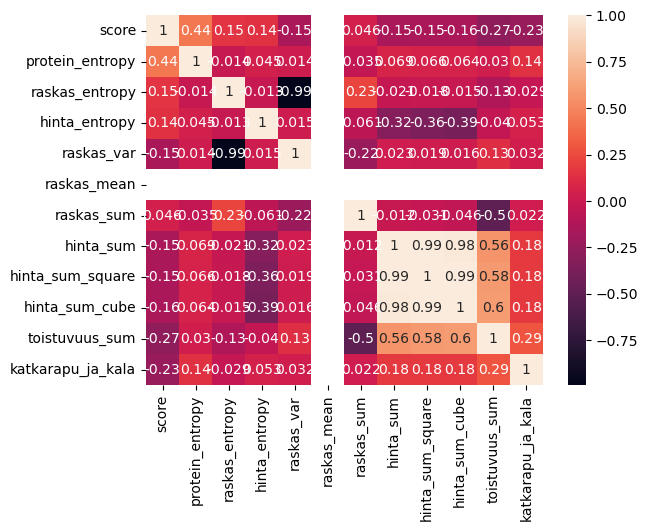

In [119]:
sns.heatmap(feature_df.iloc[:,14:].corr(), annot=True)

The correlation matrix shows that the best scores are achieved with variation in main protein, fattyness, and price.

It can also be used to identify strongly correlated features to exclude some of them from training data fed to models.

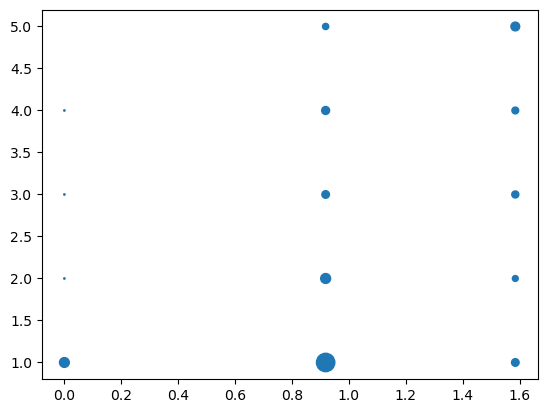

In [120]:
df = feature_df.groupby(["protein_entropy", "score"]).size().reset_index(name="count") 

plt.scatter(df["protein_entropy"], df["score"], s=df["count"])
plt.show()

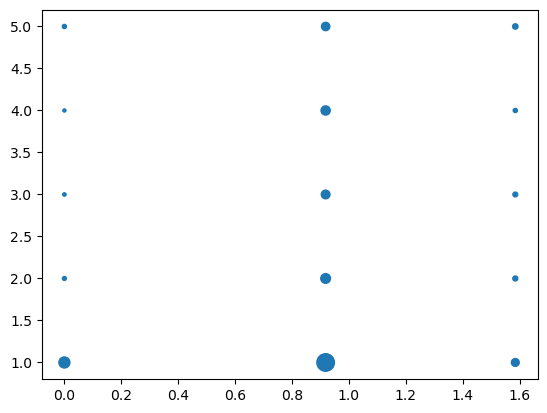

In [121]:
df = feature_df.groupby(["raskas_entropy", "score"]).size().reset_index(name="count") 

plt.scatter(df["raskas_entropy"], df["score"], s=df["count"])
plt.show()

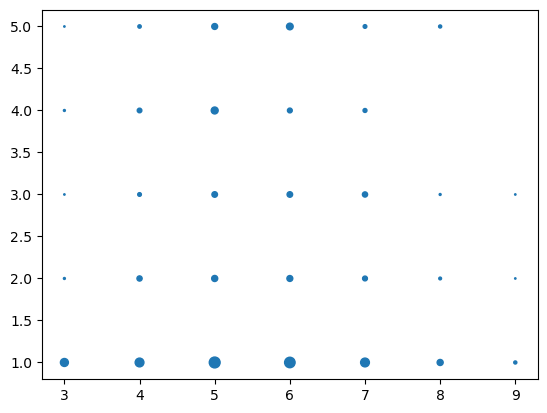

In [122]:
df = feature_df.groupby(["raskas_sum", "score"]).size().reset_index(name="count") 

plt.scatter(df["raskas_sum"], df["score"], s=df["count"])
plt.show()

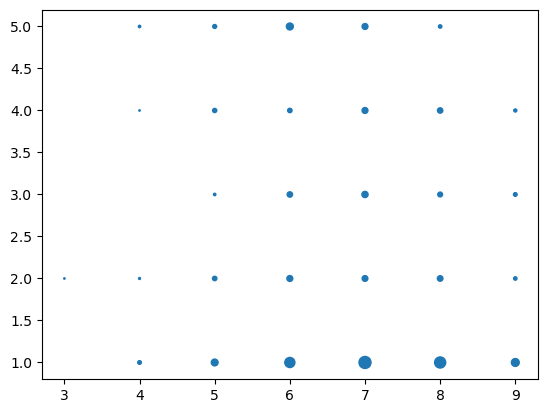

In [123]:
df = feature_df.groupby(["hinta_sum", "score"]).size().reset_index(name="count") 

plt.scatter(df["hinta_sum"], df["score"], s=df["count"])
plt.show()

The scatter plots support the previous conclusions. The feature dataframe is saved to a csv file for model training.

In [124]:
feature_df.to_csv("feature_df_v1.csv", index=False)

# Embeddings
After training models with the above features, I noticed that the models failed to capture dish variety in a set.

Then, I tried embedding the dish descriptions to vectors to capture how semantically close dishes were.

This allowed me to create a semantic similarity score for a set of dishes.

In [125]:
dish_names = dishes_df["Nimi"].to_list()
dish_descriptions: list[str] = dishes_df["Kuvaus"].to_list()

In [126]:
model = SentenceTransformer("all-MiniLM-L6-v2")
model.get_sentence_embedding_dimension()

384

In [137]:
pca = PCA(2)
embeddings = model.encode(dish_descriptions)
embeddings_2d = pca.fit_transform(embeddings)

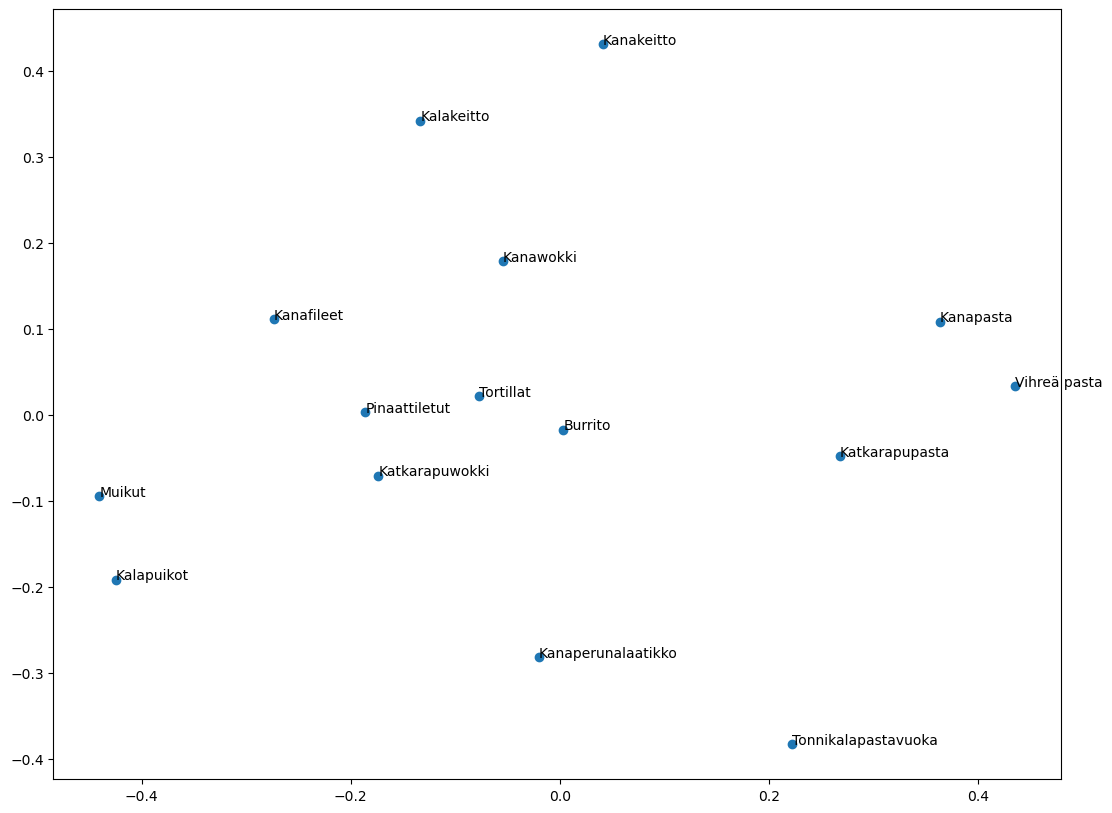

In [128]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot()

plt.scatter(embeddings_2d[:15,0], embeddings_2d[:15,1])

for i, label in enumerate(dish_names[:15]):
    x, y = embeddings_2d[i]
    ax.text(x, y, label)

Projecting the 384-dimensional embedding vectors into 2D allows us to inspect them visually.

We see that similar dishes are closer together and different dishes are further away.

Calculating a similarity score for two vectors is straightforward using, for example, cosine similarity.
However, for a group of dishes, we need to create a custom function. Through experimentation I arrived at the following formula:

$$\sqrt{\sum _i^{ }\sum _j^{ }\left|\frac{1}{A_{ij}}\right|}$$

for $i>j$ where $A$ is the similarity matrix and $A_{ij}$ is the similarity score between the i:th and j:th embedding vectors, which correspond to the i:th and j:th dish names of the given group.

In [129]:
model.similarity_fn_name = "euclidean"
# model.similarity_fn_name = "cosine"

def similarity(food_names: list[str]):
    indexes = [dish_names.index(name) for name in food_names]
    embeddings = embeddings_2d[indexes]
    sim = model.similarity(embeddings, embeddings)
    return (1/sim[tuple(torch.triu_indices(len(sim), len(sim), offset=1))].abs()).sum().sqrt().item()

In [130]:
print(similarity(["Katkarapupasta", "Kanapasta", "Vihreä pasta"])) # similar dishes
print(similarity(["Katkarapupasta", "Kanawokki", "Muikut"])) # different dishes

4.521472454071045
2.462317943572998


In [131]:
score_data["similarity"] = score_data.apply(lambda row: similarity(row[:3]), axis=1)
score_data

,a,b,c,score,similarity
0,Gnocchivuoka,Tomaattikeitto,Uuniperunat (skagen),4,2.191880
1,Tonnikalapastavuoka,Kalakeitto,Uunilohi,1,2.206034
2,Kanapasta,Vihreä pasta,Gyros,4,3.595743
3,Kalapuikot,Gnocchivuoka,Kasvislasagne,2,3.504498
4,Kalapuikot,Tonnikalapastavuoka,Savulohi,1,3.079776
...,...,...,...,...,...
495,Vihreä pasta,Gnocchivuoka,Uuniperunat (skagen),1,2.455802
496,Burrito,Halloumipasta,Paistetut nuudelit,5,4.225143
497,Tonnikalapastavuoka,Kanapasta,Uuniperunat (skagen),3,2.401671
498,Katkarapupasta,Tonnikalapastavuoka,Kanafileet,3,2.480490


<Axes: title={'center': 'similarity'}, xlabel='score'>

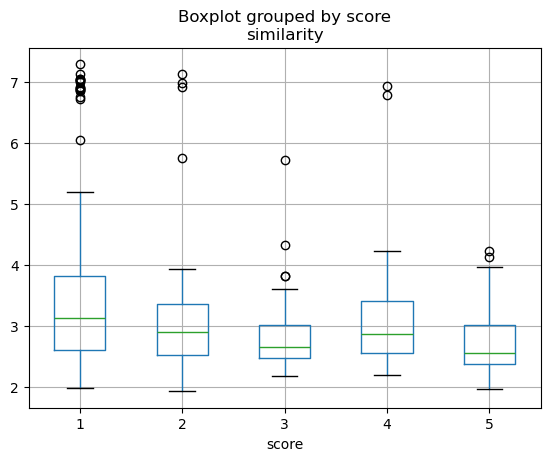

In [132]:
score_data.boxplot(column="similarity", by="score")

A slight trend can be seen where higher similarity scores result in lower scores.

## Inserting similarity scores into feature dataframe

In [133]:
score_data["dishes"] = score_data[["a", "b", "c"]].agg(", ".join, axis=1)

In [134]:
feature_df["similarity"] = score_data["similarity"]
feature_df["dishes"] = score_data["dishes"]

In [135]:
feature_df

,Pääraaka-aine_Kala,Pääraaka-aine_Kana,Pääraaka-aine_Kasvis,Pääraaka-aine_Katkarapu,Raskas_1,Raskas_2,Raskas_3,Hinta_1,Hinta_2,Hinta_3,...,raskas_var,raskas_mean,raskas_sum,hinta_sum,hinta_sum_square,hinta_sum_cube,toistuvuus_sum,katkarapu_ja_kala,similarity,dishes
0,0,0,2,1,1,1,1,1,1,1,...,0.000000,1.0,6,6,36,216,16,1,2.191880,"Gnocchivuoka, Tomaattikeitto, Uuniperunat (ska..."
1,3,0,0,0,0,2,1,0,2,1,...,0.666667,1.0,7,7,49,343,15,3,2.206034,"Tonnikalapastavuoka, Kalakeitto, Uunilohi"
2,0,2,1,0,1,2,0,0,1,2,...,0.666667,1.0,5,8,64,512,16,0,3.595743,"Kanapasta, Vihreä pasta, Gyros"
3,1,0,2,0,0,2,1,1,2,0,...,0.666667,1.0,7,5,25,125,11,1,3.504498,"Kalapuikot, Gnocchivuoka, Kasvislasagne"
4,3,0,0,0,1,1,1,1,1,1,...,0.000000,1.0,6,6,36,216,15,3,3.079776,"Kalapuikot, Tonnikalapastavuoka, Savulohi"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,0,2,1,1,1,1,0,1,2,...,0.000000,1.0,6,8,64,512,16,1,2.455802,"Vihreä pasta, Gnocchivuoka, Uuniperunat (skagen)"
496,0,2,1,0,2,0,1,0,3,0,...,0.666667,1.0,5,6,36,216,11,0,4.225143,"Burrito, Halloumipasta, Paistetut nuudelit"
497,1,1,0,1,0,2,1,0,2,1,...,0.666667,1.0,7,7,49,343,6,2,2.401671,"Tonnikalapastavuoka, Kanapasta, Uuniperunat (s..."
498,1,1,0,1,1,0,2,0,1,2,...,0.666667,1.0,7,8,64,512,15,2,2.480490,"Katkarapupasta, Tonnikalapastavuoka, Kanafileet"


In [136]:
feature_df.to_csv("feature_df_v2.csv", index=False)